In [1]:
# %% Cell 1: Enhanced Imports and Configuration
"""
Machine Learning Optimization for SRK/T Formula in FacoDMEK Eyes
Required packages: pip install pandas numpy matplotlib seaborn scikit-learn scipy openpyxl scikit-optimize
"""

# Standard library imports
import json
import warnings
from datetime import datetime
from pathlib import Path

# Data manipulation and numerical computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, 
    GridSearchCV, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.base import clone

# Optimization
from scipy.optimize import minimize, differential_evolution, dual_annealing
from scipy import stats

# Bayesian optimization
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
    SKOPT_AVAILABLE = True
except ImportError:
    print("Warning: scikit-optimize not installed. Install with: pip install scikit-optimize")
    SKOPT_AVAILABLE = False

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Global configuration
class Config:
    # Multiple seeds for analysis
    RANDOM_SEEDS = [42, 123, 456, 789, 2024]  # Add more seeds as needed
    TEST_SIZE = 0.30  # 30% test set
    CV_FOLDS = 3      # Cross-validation folds
    N_BOOTSTRAP = 1000  # Bootstrap iterations
    
    # File paths
    DATA_FILE = 'FacoDMEK.xlsx'
    OUTPUT_DIR = Path('output')
    
    # Plotting
    FIGURE_DPI = 100
    FIGURE_SIZE = (10, 6)

# Create output directory
Config.OUTPUT_DIR.mkdir(exist_ok=True)

print("Enhanced ML Pipeline for FacoDMEK IOL Calculations")
print("=" * 60)
print(f"Random Seeds: {Config.RANDOM_SEEDS}")
print(f"Number of runs: {len(Config.RANDOM_SEEDS)}")
print(f"Test Set Size: {Config.TEST_SIZE * 100:.0f}%")
print(f"Cross-validation Folds: {Config.CV_FOLDS}")
print(f"Output Directory: {Config.OUTPUT_DIR}")
print("=" * 60)

Enhanced ML Pipeline for FacoDMEK IOL Calculations
Random Seeds: [42, 123, 456, 789, 2024]
Number of runs: 5
Test Set Size: 30%
Cross-validation Folds: 3
Output Directory: output


In [2]:
# %% Cell 2: Data Loading and Advanced Feature Engineering
"""Load data and create clinically meaningful features"""

class DataProcessor:
    """Handle data loading and feature engineering"""
    
    @staticmethod
    def load_data(filepath):
        """Load and validate data"""
        try:
            df = pd.read_excel(filepath, sheet_name='Cleaned Data')
            print(f"✓ Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
            return df
        except Exception as e:
            raise ValueError(f"Error loading data: {e}")
    
    @staticmethod
    def create_features(df):
        """Create derived features based on clinical knowledge"""
        df = df.copy()
        
        # Basic derived features
        df['K_avg_Kerato'] = (df['Keratometric Ks'] + df['Keratometric Kf']) / 2
        df['K_Astigmatism_Kerato'] = df['Keratometric Ks'] - df['Keratometric Kf']
        df['K_Cylinder'] = np.abs(df['K_Astigmatism_Kerato'])
        
        # Ratios and relationships
        df['Post_Ant_Ratio'] = df['Posterior Km'] / df['Anterior Km']
        df['AL_K_Ratio'] = df['Bio-AL'] / df['K_avg_Kerato']
        
        # Advanced features
        df['K_Spherical_Equivalent'] = df['K_avg_Kerato'] + 0.5 * df['K_Cylinder']
        
        # Categorize axial length
        df['AL_Category'] = pd.cut(
            df['Bio-AL'], 
            bins=[0, 22, 24.5, 26, 100], 
            labels=['short', 'normal', 'long', 'very_long']
        )
        
        # Additional clinical features if available
        if 'Bio-ACD' in df.columns and 'Bio-LT' in df.columns:
            df['Anterior_Segment_Depth'] = df['Bio-ACD'] + 0.5 * df['Bio-LT']
            if 'Bio-AL' in df.columns:
                df['LP_Factor'] = df['Bio-ACD'] / (df['Bio-AL'] - df['Bio-LT'])
        
        # CCT categories if available
        if 'CCT' in df.columns:
            df['CCT_Category'] = pd.cut(
                df['CCT'],
                bins=[0, 500, 550, 600, 1000],
                labels=['thin', 'normal', 'thick', 'very_thick']
            )
            df['CCT_K_Interaction'] = df['CCT'] * df['K_avg_Kerato'] / 1000
        
        return df
    
    @staticmethod
    def get_feature_summary(df):
        """Print feature summary statistics"""
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        print("\nFeature Summary:")
        print("-" * 60)
        for col in ['Bio-AL', 'K_avg_Kerato', 'CCT', 'IOL Power']:
            if col in df.columns:
                print(f"{col:20s}: μ={df[col].mean():.2f}, σ={df[col].std():.2f}, "
                      f"range=[{df[col].min():.1f}, {df[col].max():.1f}]")

# Load and process data (only once, outside the seed loop)
processor = DataProcessor()
df_original = processor.load_data(Config.DATA_FILE)
df_original = processor.create_features(df_original)
processor.get_feature_summary(df_original)

print(f"\n✓ Feature engineering completed: {len(df_original.columns)} total features")

✓ Data loaded successfully: 97 rows, 29 columns

Feature Summary:
------------------------------------------------------------
Bio-AL              : μ=23.83, σ=1.38, range=[21.2, 28.2]
K_avg_Kerato        : μ=43.60, σ=1.88, range=[39.0, 47.3]
CCT                 : μ=620.57, σ=79.40, range=[448.0, 880.0]
IOL Power           : μ=21.46, σ=4.12, range=[11.0, 30.0]

✓ Feature engineering completed: 40 total features


In [3]:
# %% Cell 3: Core Classes
"""Define all the core classes that will be used in the multi-seed analysis"""

class DataSplitter:
    """Handle data splitting with validation"""
    
    def __init__(self, test_size=0.3, random_state=42):
        self.test_size = test_size
        self.random_state = random_state
        self.required_cols = [
            'Bio-AL', 'K_avg_Kerato', 'IOL Power', 
            'PostOP Spherical Equivalent', 'A-Constant'
        ]
    
    def split_data(self, df):
        """Create train/test split with stratification"""
        # Filter complete cases
        df_complete = df[df[self.required_cols].notna().all(axis=1)].copy()
        
        print(f"Complete cases: {len(df_complete)} / {len(df)} ({len(df_complete)/len(df)*100:.1f}%)")
        
        # Stratified split by AL category
        df_train, df_test = train_test_split(
            df_complete,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=df_complete['AL_Category']
        )
        
        return df_train, df_test
    
    def validate_split(self, df_train, df_test):
        """Validate the data split"""
        print("\nData Split Validation:")
        print("-" * 40)
        print(f"Training set: {len(df_train)} eyes ({len(df_train)/(len(df_train)+len(df_test))*100:.1f}%)")
        print(f"Test set: {len(df_test)} eyes ({len(df_test)/(len(df_train)+len(df_test))*100:.1f}%)")
        
        # Check distributions
        print("\nAL Distribution:")
        for name, data in [("Train", df_train), ("Test", df_test)]:
            dist = data['AL_Category'].value_counts(normalize=True).sort_index()
            print(f"{name}: " + " | ".join([f"{cat}: {pct*100:.1f}%" for cat, pct in dist.items()]))
        
        # Statistical tests for distribution similarity
        for col in ['Bio-AL', 'K_avg_Kerato']:
            stat, pval = stats.ks_2samp(df_train[col], df_test[col])
            print(f"\nKS test for {col}: p={pval:.3f} {'✓' if pval > 0.05 else '✗'}")


class SRKTCalculator:
    """SRK/T IOL power calculation with enhancements"""
    
    # Standard constants
    NA = 1.336  # Aqueous/vitreous refractive index
    VERTEX = 12.0  # Vertex distance in mm
    
    @staticmethod
    def calculate(AL, K, A_const, nc=1.333):
        """
        Calculate IOL power using SRK/T formula
        
        Parameters:
        -----------
        AL : float - Axial length (mm)
        K : float - Average keratometry (D)
        A_const : float - A-constant
        nc : float - Corneal refractive index (default: 1.333)
        
        Returns:
        --------
        float - IOL power for emmetropia (D)
        """
        # Input validation
        if any(pd.isna([AL, K, A_const])) or K <= 0 or AL <= 0:
            return np.nan
        
        # Bounds checking
        if not (15 < AL < 35) or not (35 < K < 55):
            return np.nan
        
        try:
            # Corneal radius
            r = 337.5 / K
            
            # Axial length correction
            if AL > 24.2:
                LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
            else:
                LCOR = AL
            
            # Corneal width
            Cw = -5.41 + 0.58412 * LCOR + 0.098 * K
            
            # Safety check for corneal height calculation
            discriminant = r**2 - (Cw**2 / 4)
            if discriminant < 0:
                return np.nan
            
            # Corneal height
            H = r - np.sqrt(discriminant)
            
            # ACD estimation
            ACDconst = 0.62467 * A_const - 68.747
            offset = ACDconst - 3.336
            ACDest = H + offset
            
            # Retinal thickness
            RETHICK = 0.65696 - 0.02029 * AL
            LOPT = AL + RETHICK
            
            # IOL power calculation
            ncm1 = nc - 1
            numerator = 1000 * SRKTCalculator.NA * (SRKTCalculator.NA * r - ncm1 * LOPT)
            denominator = (LOPT - ACDest) * (SRKTCalculator.NA * r - ncm1 * ACDest)
            
            if denominator == 0:
                return np.nan
                
            IOL = numerator / denominator
            
            # Sanity check on IOL power
            if not (-10 < IOL < 40):
                return np.nan
                
            return IOL
            
        except Exception:
            return np.nan
    
    @staticmethod
    def calculate_error(row, nc=1.333):
        """Calculate prediction error for a single case"""
        iol_pred = SRKTCalculator.calculate(
            row['Bio-AL'], 
            row['K_avg_Kerato'], 
            row['A-Constant'], 
            nc
        )
        
        if pd.isna(iol_pred):
            return np.nan
        
        expected_se = -(row['IOL Power'] - iol_pred)
        error = row['PostOP Spherical Equivalent'] - expected_se
        
        return error

In [4]:
# %% Cell 4: More Core Classes
"""NC Optimizer and Ensemble Builder classes"""

class NCOptimizer:
    """Optimize corneal refractive index using cross-validation"""
    
    def __init__(self, nc_range=(1.330, 1.338), n_points=41):
        self.nc_range = nc_range
        self.nc_values = np.linspace(nc_range[0], nc_range[1], n_points)
        self.results = None
        
    def objective_function(self, nc, df, cv_folds=3, random_state=42):
        """Calculate CV score for given nc value"""
        kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        fold_scores = []
        
        for train_idx, val_idx in kf.split(df):
            val_data = df.iloc[val_idx]
            
            # Calculate errors for validation fold
            errors = val_data.apply(
                lambda row: SRKTCalculator.calculate_error(row, nc=nc),
                axis=1
            ).dropna()
            
            if len(errors) > 0:
                fold_scores.append(errors.abs().mean())
        
        return np.mean(fold_scores) if fold_scores else np.inf
    
    def optimize(self, df_train, cv_folds=3, random_state=42):
        """Find optimal nc value"""
        print(f"Testing {len(self.nc_values)} nc values from {self.nc_range[0]} to {self.nc_range[1]}")
        
        # Filter training data
        df_opt = df_train[df_train['SRKT_Error'].notna()].copy()
        
        # Calculate scores
        scores = []
        for i, nc in enumerate(self.nc_values):
            score = self.objective_function(nc, df_opt, cv_folds=cv_folds, 
                                          random_state=random_state)
            scores.append(score)
            
            if (i + 1) % 10 == 0:
                print(f"  Progress: {i+1}/{len(self.nc_values)}")
        
        # Find optimal value
        scores = np.array(scores)
        best_idx = np.argmin(scores)
        self.optimal_nc = self.nc_values[best_idx]
        self.optimal_score = scores[best_idx]
        self.results = pd.DataFrame({'nc': self.nc_values, 'cv_mae': scores})
        
        return self.optimal_nc, self.optimal_score


class EnsembleBuilder:
    """Build and optimize ensemble model"""
    
    def __init__(self, feature_cols=None, use_bayesian=True, random_state=42):
        self.feature_cols = feature_cols or [
            'Bio-AL', 'K_avg_Kerato', 'A-Constant', 'K_Cylinder',
            'Post_Ant_Ratio', 'AL_K_Ratio', 'CCT'
        ]
        self.use_bayesian = use_bayesian and SKOPT_AVAILABLE
        self.random_state = random_state
        self.models = {}
        self.ensemble = None
        self.imputer = KNNImputer(n_neighbors=5)
        
    def add_optional_features(self, df):
        """Add optional features if available"""
        optional_features = [
            'Posterior Km', 'Anterior Km', 'Bio-ACD', 'Bio-LT',
            'Anterior_Segment_Depth', 'LP_Factor', 'CCT_K_Interaction'
        ]
        
        for feat in optional_features:
            if feat in df.columns and feat not in self.feature_cols:
                self.feature_cols.append(feat)
        
        return self.feature_cols
    
    def prepare_features(self, df, fit_imputer=True):
        """Prepare features with imputation"""
        X = df[self.feature_cols].copy()
        
        if fit_imputer:
            X_imputed = self.imputer.fit_transform(X)
        else:
            X_imputed = self.imputer.transform(X)
        
        return pd.DataFrame(X_imputed, columns=self.feature_cols, index=X.index)
    
    def create_base_models(self):
        """Create base model pipelines"""
        models = {
            'ridge': Pipeline([
                ('scaler', RobustScaler()),
                ('model', Ridge())
            ]),
            'huber': Pipeline([
                ('scaler', RobustScaler()),
                ('model', HuberRegressor())
            ]),
            'rf': Pipeline([
                ('scaler', RobustScaler()),
                ('model', RandomForestRegressor(random_state=self.random_state))
            ]),
            'elastic': Pipeline([
                ('scaler', StandardScaler()),
                ('model', ElasticNet(random_state=self.random_state))
            ])
        }
        
        return models
    
    def get_search_spaces(self):
        """Define hyperparameter search spaces"""
        return {
            'ridge': {
                'model__alpha': Real(0.1, 100.0, prior='log-uniform')
            },
            'huber': {
                'model__epsilon': Real(1.0, 2.0),
                'model__alpha': Real(0.001, 0.1, prior='log-uniform')
            },
            'rf': {
                'model__n_estimators': Integer(10, 50),
                'model__max_depth': Integer(2, 5),
                'model__min_samples_split': Integer(10, 30),
                'model__min_samples_leaf': Integer(5, 20)
            },
            'elastic': {
                'model__alpha': Real(0.01, 1.0, prior='log-uniform'),
                'model__l1_ratio': Real(0.1, 0.9)
            }
        }
    
    def optimize_models(self, X_train, y_train, cv_folds=3):
        """Optimize individual models"""
        base_models = self.create_base_models()
        
        if self.use_bayesian:
            print("Using Bayesian optimization for hyperparameter tuning...")
            search_spaces = self.get_search_spaces()
            
            for name, model in base_models.items():
                print(f"\nOptimizing {name}...")
                
                optimizer = BayesSearchCV(
                    model,
                    search_spaces[name],
                    n_iter=20 if name != 'rf' else 30,
                    cv=cv_folds,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    random_state=self.random_state
                )
                
                optimizer.fit(X_train, y_train)
                self.models[name] = optimizer.best_estimator_
                
                print(f"  Best params: {optimizer.best_params_}")
                print(f"  Best CV MAE: {-optimizer.best_score_:.3f}")
        else:
            print("Using default hyperparameters...")
            # Use reasonable defaults
            defaults = {
                'ridge': {'model__alpha': 10.0},
                'huber': {'model__epsilon': 1.5, 'model__alpha': 0.01},
                'rf': {'model__n_estimators': 20, 'model__max_depth': 3},
                'elastic': {'model__alpha': 0.1, 'model__l1_ratio': 0.5}
            }
            
            for name, model in base_models.items():
                model.set_params(**defaults[name])
                model.fit(X_train, y_train)
                self.models[name] = model
                
                # Calculate CV score
                cv_scores = cross_val_score(
                    model, X_train, y_train,
                    cv=cv_folds,
                    scoring='neg_mean_absolute_error'
                )
                print(f"{name}: CV MAE = {-cv_scores.mean():.3f}")
    
    def create_ensemble(self, X_train, y_train, cv_folds=3):
        """Create and train ensemble"""
        # Optimize individual models
        self.optimize_models(X_train, y_train, cv_folds=cv_folds)
        
        # Create voting ensemble
        self.ensemble = VotingRegressor([
            (name, model) for name, model in self.models.items()
        ])
        
        # Train ensemble
        self.ensemble.fit(X_train, y_train)
        
        # Evaluate ensemble
        cv_scores = cross_val_score(
            self.ensemble, X_train, y_train,
            cv=cv_folds,
            scoring='neg_mean_absolute_error'
        )
        
        print(f"\nEnsemble CV MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
        
        return self.ensemble
    
    def optimize_dampening(self, X_train, y_train, df_train, nc_predictions):
        """Find optimal dampening factor"""
        dampening_range = np.arange(0.3, 0.8, 0.1)
        best_dampening = 0.5
        best_mae = float('inf')
        
        print("\nOptimizing dampening factor...")
        
        # Get ensemble predictions
        ensemble_corrections = self.ensemble.predict(X_train)
        
        for damp in dampening_range:
            # Apply dampened corrections
            final_predictions = nc_predictions + damp * ensemble_corrections
            
            # Calculate error
            expected_se = -(df_train['IOL Power'] - final_predictions)
            errors = df_train['PostOP Spherical Equivalent'] - expected_se
            mae = errors.abs().mean()
            
            print(f"  Dampening {damp:.1f}: MAE = {mae:.3f}")
            
            if mae < best_mae:
                best_mae = mae
                best_dampening = damp
        
        return best_dampening, ensemble_corrections


class ModelEvaluator:
    """Comprehensive model evaluation and comparison"""
    
    def __init__(self, model_info):
        self.model_info = model_info
        self.results = {}
        
    def calculate_clinical_metrics(self, errors):
        """Calculate comprehensive clinical metrics"""
        abs_errors = errors.abs()
        
        return {
            'n': len(errors),
            'mae': abs_errors.mean(),
            'median_ae': abs_errors.median(),
            'std': abs_errors.std(),
            'rmse': np.sqrt((errors ** 2).mean()),
            'max_error': abs_errors.max(),
            'within_025': (abs_errors <= 0.25).mean() * 100,
            'within_050': (abs_errors <= 0.50).mean() * 100,
            'within_100': (abs_errors <= 1.00).mean() * 100,
            'within_200': (abs_errors <= 2.00).mean() * 100
        }
    
    def evaluate_all_models(self, df_test):
        """Evaluate all model variants"""
        print("\nEvaluating models on test set...")
        print("=" * 60)
        
        df_eval = df_test.copy()
        
        # 1. Baseline SRK/T
        print("1. Baseline SRK/T (nc=1.333)...")
        df_eval['Error_Baseline'] = df_eval.apply(
            lambda row: SRKTCalculator.calculate_error(row, nc=1.333),
            axis=1
        )
        
        # 2. Optimized NC
        print("2. ML-Optimized NC...")
        df_eval['Error_ML_nc'] = df_eval.apply(
            lambda row: SRKTCalculator.calculate_error(row, nc=self.model_info['optimal_nc']),
            axis=1
        )
        
        # 3. ML + Ensemble
        print("3. ML + Ensemble...")
        
        # Prepare features
        builder = self.model_info['builder']
        X_test = builder.prepare_features(df_eval, fit_imputer=False)
        
        # Get predictions
        nc_predictions = df_eval.apply(
            lambda row: SRKTCalculator.calculate(
                row['Bio-AL'], row['K_avg_Kerato'], 
                row['A-Constant'], nc=self.model_info['optimal_nc']
            ),
            axis=1
        )
        
        ensemble_corrections = self.model_info['ensemble'].predict(X_test)
        final_predictions = nc_predictions + self.model_info['dampening_factor'] * ensemble_corrections
        
        df_eval['SRKT_Final'] = final_predictions
        df_eval['Error_Final'] = df_eval.apply(
            lambda row: row['PostOP Spherical Equivalent'] - (-(row['IOL Power'] - row['SRKT_Final'])),
            axis=1
        )
        
        # Calculate metrics for each method
        methods = {
            'Baseline SRK/T': df_eval['Error_Baseline'],
            'ML-Optimized NC': df_eval['Error_ML_nc'],
            'ML + Ensemble': df_eval['Error_Final']
        }
        
        results_summary = []
        for method, errors in methods.items():
            metrics = self.calculate_clinical_metrics(errors.dropna())
            metrics['Method'] = method
            results_summary.append(metrics)
            self.results[method] = metrics
        
        # Create results dataframe
        self.results_df = pd.DataFrame(results_summary)
        
        # Reorder columns
        col_order = ['Method', 'n', 'mae', 'median_ae', 'std', 'rmse', 
                     'within_025', 'within_050', 'within_100', 'max_error']
        self.results_df = self.results_df[col_order]
        
        return df_eval, self.results_df

In [5]:
# %% Cell 5: Main Analysis Function
"""Function to run complete analysis for one seed"""

def run_single_seed_analysis(df, seed, verbose=True):
    """Run complete analysis for a single random seed"""
    
    if verbose:
        print(f"\n{'='*80}")
        print(f"RUNNING ANALYSIS WITH SEED: {seed}")
        print(f"{'='*80}")
    
    # Set random seed
    np.random.seed(seed)
    
    # Split data
    splitter = DataSplitter(test_size=Config.TEST_SIZE, random_state=seed)
    df_train_val, df_test = splitter.split_data(df)
    
    if verbose:
        splitter.validate_split(df_train_val, df_test)
    
    # Calculate baseline performance
    if verbose:
        print("\nCalculating baseline SRK/T performance...")
    
    df_train_val['SRKT_Baseline'] = df_train_val.apply(
        lambda row: SRKTCalculator.calculate(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']),
        axis=1
    )
    
    df_train_val['SRKT_Error'] = df_train_val.apply(
        lambda row: SRKTCalculator.calculate_error(row),
        axis=1
    )
    
    # Performance metrics
    valid_errors = df_train_val['SRKT_Error'].dropna()
    baseline_mae = valid_errors.abs().mean()
    
    if verbose:
        print(f"\nBaseline Performance:")
        print(f"  MAE: {baseline_mae:.3f} D")
        print(f"  n:   {len(valid_errors)} eyes")
    
    # Optimize nc
    optimizer = NCOptimizer(nc_range=(1.330, 1.338), n_points=41)
    df_opt_train = df_train_val[df_train_val['SRKT_Error'].notna()].copy()
    
    optimal_nc, optimal_score = optimizer.optimize(df_opt_train, cv_folds=Config.CV_FOLDS, 
                                                  random_state=seed)
    
    if verbose:
        print(f"\n✓ Optimization Complete!")
        print(f"  Optimal nc: {optimal_nc:.5f}")
        print(f"  CV MAE: {optimal_score:.3f} D")
    
    # Apply optimal nc
    df_opt_train['Error_ML_nc'] = df_opt_train.apply(
        lambda row: SRKTCalculator.calculate_error(row, nc=optimal_nc),
        axis=1
    )
    
    ml_nc_mae = df_opt_train['Error_ML_nc'].abs().mean()
    
    # Build ensemble
    if verbose:
        print("\nBuilding ML Ensemble...")
    
    builder = EnsembleBuilder(random_state=seed)
    builder.add_optional_features(df_opt_train)
    
    # Prepare data
    X_train = builder.prepare_features(df_opt_train, fit_imputer=True)
    y_residuals = df_opt_train['Error_ML_nc']
    
    # Build ensemble
    ensemble = builder.create_ensemble(X_train, y_residuals, cv_folds=Config.CV_FOLDS)
    
    # Optimize dampening
    nc_predictions = df_opt_train.apply(
        lambda row: SRKTCalculator.calculate(
            row['Bio-AL'], row['K_avg_Kerato'], 
            row['A-Constant'], nc=optimal_nc
        ),
        axis=1
    )
    
    best_dampening, ensemble_corrections = builder.optimize_dampening(
        X_train, y_residuals, df_opt_train, nc_predictions
    )
    
    if verbose:
        print(f"\n✓ Best dampening factor: {best_dampening:.1f}")
    
    # Apply final corrections
    df_opt_train['SRKT_Final'] = nc_predictions + best_dampening * ensemble_corrections
    df_opt_train['Error_Final'] = df_opt_train.apply(
        lambda row: row['PostOP Spherical Equivalent'] - (-(row['IOL Power'] - row['SRKT_Final'])),
        axis=1
    )
    
    # Final performance
    final_mae = df_opt_train['Error_Final'].abs().mean()
    
    # Save model info
    model_info = {
        'optimal_nc': optimal_nc,
        'ensemble': ensemble,
        'builder': builder,
        'dampening_factor': best_dampening,
        'random_seed': seed,
        'feature_cols': builder.feature_cols,
        'imputer': builder.imputer
    }
    
    # Evaluate on test set
    evaluator = ModelEvaluator(model_info)
    df_test_eval, results_df = evaluator.evaluate_all_models(df_test)
    
    if verbose:
        print("\nTest Set Results Summary:")
        print("=" * 60)
        print(results_df.to_string(index=False, float_format=lambda x: f'{x:.3f}' if x < 10 else f'{x:.1f}'))
    
    # Collect results
    results = {
        'seed': seed,
        'optimal_nc': optimal_nc,
        'dampening_factor': best_dampening,
        'train_baseline_mae': baseline_mae,
        'train_ml_nc_mae': ml_nc_mae,
        'train_final_mae': final_mae,
        'test_baseline_mae': results_df[results_df['Method'] == 'Baseline SRK/T']['mae'].values[0],
        'test_ml_nc_mae': results_df[results_df['Method'] == 'ML-Optimized NC']['mae'].values[0],
        'test_final_mae': results_df[results_df['Method'] == 'ML + Ensemble']['mae'].values[0],
        'test_final_within_050': results_df[results_df['Method'] == 'ML + Ensemble']['within_050'].values[0],
        'test_final_within_100': results_df[results_df['Method'] == 'ML + Ensemble']['within_100'].values[0],
        'improvement_percent': ((results_df[results_df['Method'] == 'Baseline SRK/T']['mae'].values[0] - 
                                results_df[results_df['Method'] == 'ML + Ensemble']['mae'].values[0]) / 
                               results_df[results_df['Method'] == 'Baseline SRK/T']['mae'].values[0] * 100)
    }
    
    return results, model_info, df_test_eval

In [6]:
# %% Cell 6: Multi-Seed Analysis
"""Run analysis across multiple seeds and summarize results"""

# Run analysis for each seed
all_results = []
all_model_infos = []

for i, seed in enumerate(Config.RANDOM_SEEDS):
    print(f"\n{'#'*80}")
    print(f"PROGRESS: {i+1}/{len(Config.RANDOM_SEEDS)} seeds completed")
    print(f"{'#'*80}")
    
    results, model_info, df_test_eval = run_single_seed_analysis(
        df_original, 
        seed, 
        verbose=True  # Set to False for less output
    )
    
    all_results.append(results)
    all_model_infos.append(model_info)

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("MULTI-SEED ANALYSIS COMPLETE!")
print("="*80)

# Summary statistics
print("\n1. OPTIMAL NC VALUES ACROSS SEEDS:")
print("-" * 40)
print(f"Mean: {results_df['optimal_nc'].mean():.5f}")
print(f"Std:  {results_df['optimal_nc'].std():.5f}")
print(f"Min:  {results_df['optimal_nc'].min():.5f}")
print(f"Max:  {results_df['optimal_nc'].max():.5f}")

print("\n2. TEST SET MAE ACROSS SEEDS:")
print("-" * 40)
for method in ['test_baseline_mae', 'test_ml_nc_mae', 'test_final_mae']:
    method_name = method.replace('test_', '').replace('_mae', '').replace('_', ' ').title()
    print(f"\n{method_name}:")
    print(f"  Mean: {results_df[method].mean():.3f} D")
    print(f"  Std:  {results_df[method].std():.3f} D")
    print(f"  Range: [{results_df[method].min():.3f}, {results_df[method].max():.3f}]")

print("\n3. IMPROVEMENT PERCENTAGE:")
print("-" * 40)
print(f"Mean improvement: {results_df['improvement_percent'].mean():.1f}%")
print(f"Std improvement:  {results_df['improvement_percent'].std():.1f}%")
print(f"Range: [{results_df['improvement_percent'].min():.1f}%, {results_df['improvement_percent'].max():.1f}%]")

print("\n4. CLINICAL ACCURACY (ML + Ensemble):")
print("-" * 40)
print(f"Within ±0.50D: {results_df['test_final_within_050'].mean():.1f}% (±{results_df['test_final_within_050'].std():.1f}%)")
print(f"Within ±1.00D: {results_df['test_final_within_100'].mean():.1f}% (±{results_df['test_final_within_100'].std():.1f}%)")

# Save detailed results
results_df.to_csv(Config.OUTPUT_DIR / 'multi_seed_results.csv', index=False)
print(f"\n✓ Detailed results saved to: {Config.OUTPUT_DIR / 'multi_seed_results.csv'}")

# Display full results table
print("\nDETAILED RESULTS BY SEED:")
print("="*80)
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.3f}' if x < 10 else f'{x:.1f}'))


################################################################################
PROGRESS: 1/5 seeds completed
################################################################################

RUNNING ANALYSIS WITH SEED: 42
Complete cases: 97 / 97 (100.0%)

Data Split Validation:
----------------------------------------
Training set: 67 eyes (69.1%)
Test set: 30 eyes (30.9%)

AL Distribution:
Train: short: 7.5% | normal: 65.7% | long: 17.9% | very_long: 9.0%
Test: short: 6.7% | normal: 63.3% | long: 20.0% | very_long: 10.0%

KS test for Bio-AL: p=0.842 ✓

KS test for K_avg_Kerato: p=0.531 ✓

Calculating baseline SRK/T performance...

Baseline Performance:
  MAE: 1.637 D
  n:   67 eyes
Testing 41 nc values from 1.33 to 1.338
  Progress: 10/41
  Progress: 20/41
  Progress: 30/41
  Progress: 40/41

✓ Optimization Complete!
  Optimal nc: 1.33000
  CV MAE: 1.413 D

Building ML Ensemble...
Using Bayesian optimization for hyperparameter tuning...

Optimizing ridge...
  Best params: OrderedDi

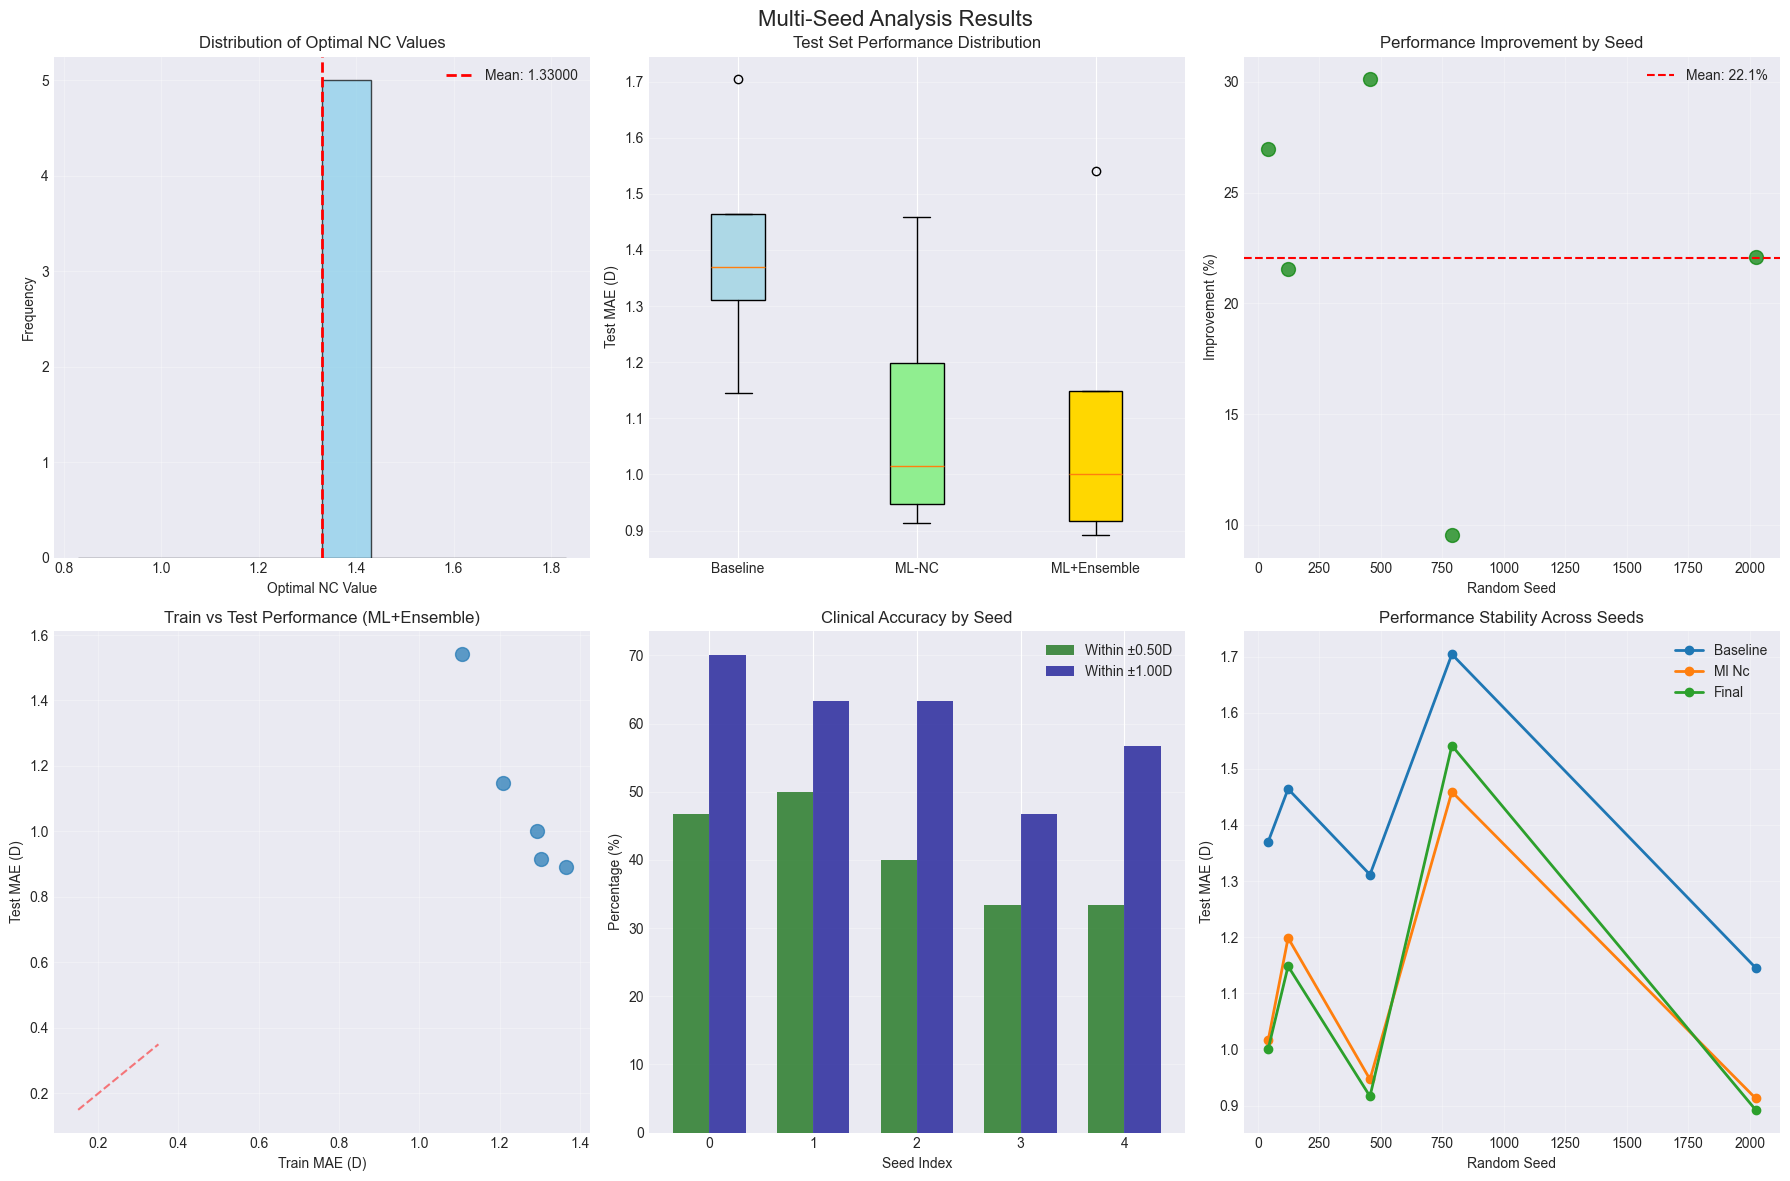


FINAL SUMMARY
Analysis completed with 5 random seeds
Average optimal nc: 1.33000 ± 0.00000
Average test MAE: 1.100 ± 0.266 D
Average improvement: 22.1 ± 7.8%
All results saved to: output


In [7]:
# %% Cell 7: Visualization of Multi-Seed Results
"""Create comprehensive visualizations for multi-seed analysis"""

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Multi-Seed Analysis Results', fontsize=16)

# 1. Optimal NC Distribution
ax = axes[0, 0]
ax.hist(results_df['optimal_nc'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
ax.axvline(results_df['optimal_nc'].mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {results_df["optimal_nc"].mean():.5f}')
ax.set_xlabel('Optimal NC Value')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Optimal NC Values')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Test MAE by Method
ax = axes[0, 1]
mae_data = results_df[['test_baseline_mae', 'test_ml_nc_mae', 'test_final_mae']].values
methods = ['Baseline', 'ML-NC', 'ML+Ensemble']
positions = range(len(methods))

bp = ax.boxplot(mae_data, positions=positions, patch_artist=True, labels=methods)
colors = ['lightblue', 'lightgreen', 'gold']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Test MAE (D)')
ax.set_title('Test Set Performance Distribution')
ax.grid(True, alpha=0.3, axis='y')

# 3. Improvement Percentage
ax = axes[0, 2]
ax.scatter(results_df['seed'], results_df['improvement_percent'], s=100, alpha=0.7, color='green')
ax.axhline(results_df['improvement_percent'].mean(), color='red', linestyle='--', 
           label=f'Mean: {results_df["improvement_percent"].mean():.1f}%')
ax.set_xlabel('Random Seed')
ax.set_ylabel('Improvement (%)')
ax.set_title('Performance Improvement by Seed')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Train vs Test Performance
ax = axes[1, 0]
ax.scatter(results_df['train_final_mae'], results_df['test_final_mae'], s=100, alpha=0.7)
ax.plot([0.15, 0.35], [0.15, 0.35], 'r--', alpha=0.5)  # Identity line
ax.set_xlabel('Train MAE (D)')
ax.set_ylabel('Test MAE (D)')
ax.set_title('Train vs Test Performance (ML+Ensemble)')
ax.grid(True, alpha=0.3)

# 5. Clinical Accuracy
ax = axes[1, 1]
x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['test_final_within_050'], width, 
                label='Within ±0.50D', color='darkgreen', alpha=0.7)
bars2 = ax.bar(x + width/2, results_df['test_final_within_100'], width, 
                label='Within ±1.00D', color='darkblue', alpha=0.7)

ax.set_xlabel('Seed Index')
ax.set_ylabel('Percentage (%)')
ax.set_title('Clinical Accuracy by Seed')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 6. Performance Stability
ax = axes[1, 2]
methods_to_plot = ['test_baseline_mae', 'test_ml_nc_mae', 'test_final_mae']
for i, method in enumerate(methods_to_plot):
    label = method.replace('test_', '').replace('_mae', '').replace('_', ' ').title()
    ax.plot(results_df['seed'], results_df[method], marker='o', label=label, linewidth=2)

ax.set_xlabel('Random Seed')
ax.set_ylabel('Test MAE (D)')
ax.set_title('Performance Stability Across Seeds')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / 'multi_seed_analysis.png', dpi=Config.FIGURE_DPI, bbox_inches='tight')
plt.show()

# Print final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"Analysis completed with {len(Config.RANDOM_SEEDS)} random seeds")
print(f"Average optimal nc: {results_df['optimal_nc'].mean():.5f} ± {results_df['optimal_nc'].std():.5f}")
print(f"Average test MAE: {results_df['test_final_mae'].mean():.3f} ± {results_df['test_final_mae'].std():.3f} D")
print(f"Average improvement: {results_df['improvement_percent'].mean():.1f} ± {results_df['improvement_percent'].std():.1f}%")
print(f"All results saved to: {Config.OUTPUT_DIR}")